In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_system import linear_system

In [2]:
fs = 1000
gamma = 30
plant_b = np.array([-2, -10])
plant_a = np.array([1, -2, 1])
reference_b = np.array([3])
reference_a = np.array([1, 3])
filter_b = np.array([1])
filter_a = np.array([1,1])

Gp = linear_system(b=plant_b,
                   a=plant_a, 
                   sampling_rate=fs)
Gp.set_null_state()

Wm = linear_system(b=reference_b,
                   a=reference_a, 
                   sampling_rate=fs)
Wm.set_null_state()

Fy = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)
Fy.set_null_state()

Fu = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)
Fu.set_null_state()

rho = (plant_b[-1]/plant_a[-1])/(reference_b[-1]/reference_a[-1])

In [3]:
t_start = 0
t_end = 300

t_sim = np.arange(t_start, t_end, 1/fs)

In [4]:
input_signal = np.sign(np.sin(2*np.pi*t_sim/20))
y = 0
filtered_u = 0
filtered_y = 0

In [5]:
N_states = 2+2*(len(filter_a)-1) # r, y, omega1, omega2  
theta = np.zeros(N_states)

output_signal = np.zeros(len(t_sim))
states_history = np.zeros((N_states,len(t_sim)))

# reference signal
ym,_  = Wm.simulate(input_signal, np.zeros(len(reference_a)-1))

for i in range(len(t_sim)):
    # Controler
    omega = np.array([input_signal[i], y, filtered_u, filtered_y])
    states_history[:,i] = theta
    u = omega@theta

    # Unknown plant 
    y = Gp.iterate(u)
    output_signal[i] = y

    # Filtered states
    filtered_u = Fu.iterate(u)
    filtered_y = Fy.iterate(y)
    #estimation error
    error = y - ym[i]
    # Controler Parameters update
    m2 = 1+omega@omega
    theta = theta - gamma * omega * error * np.sign(rho)/(m2*fs)

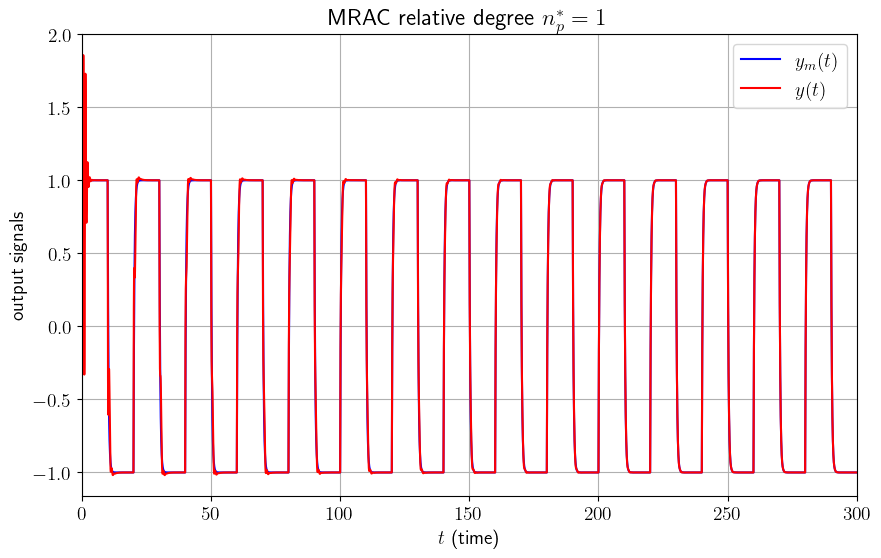

In [6]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.plot(t_sim, ym, 'b', label=r'$y_m(t)$')
plt.plot(t_sim, output_signal, 'r', label=r'$y(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'output signals')
plt.title(r'MRAC relative degree $n_p^*=1$')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
plt.show()

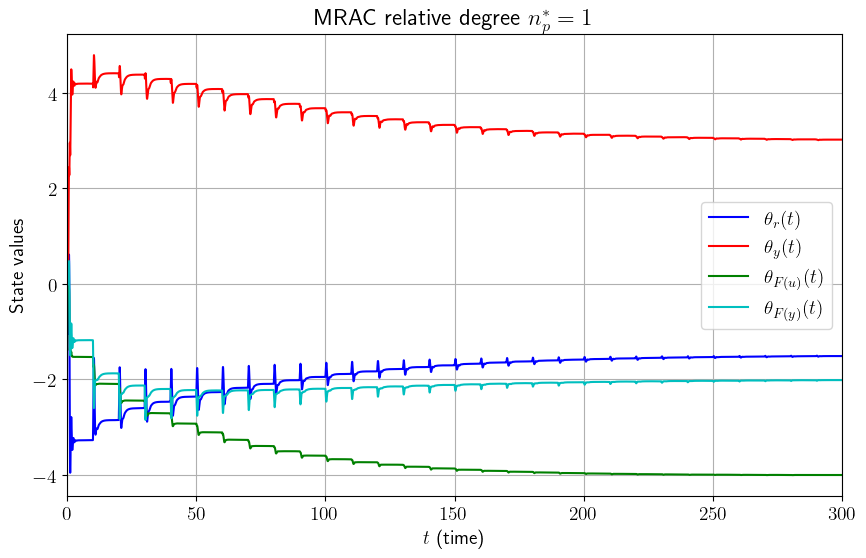

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t_sim, states_history[0,:], 'b', label=r'$\theta_r(t)$')
plt.plot(t_sim, states_history[1,:], 'r', label=r'$\theta_y(t)$')
plt.plot(t_sim, states_history[2,:], 'g', label=r'$\theta_{F(u)}(t)$')
plt.plot(t_sim, states_history[3,:], 'c', label=r'$\theta_{F(y)}(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'State values')
plt.title(r'MRAC relative degree $n_p^*=1$')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
plt.show()